In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import numpy as np
from datetime import datetime
from sklearn.feature_selection import VarianceThreshold
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings("ignore")

/Users/chrisjamal/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_excel('data.xlsx')

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
df.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


In [6]:
df.isnull()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
525456,False,False,False,False,False,False,False,False
525457,False,False,False,False,False,False,False,False
525458,False,False,False,False,False,False,False,False
525459,False,False,False,False,False,False,False,False


In [7]:
# Chain operations to clean and transform data
df = (df.assign(**{
    'Customer ID': lambda x: x['Customer ID'].fillna(0).astype(int),
    'InvoiceDate': lambda x: pd.to_datetime(x['InvoiceDate'], errors='coerce'),
    'Country': lambda x: x['Country'].astype('category')
}))

# Display modified dtypes
print(df.dtypes)

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID             int64
Country              category
dtype: object


In [8]:
# Assuming 'df' is your DataFrame

# Chain operations to clean, filter, and aggregate data in a single fluent sequence
customer_df = (
    df.dropna(subset=['Customer ID'])  # Drop rows where 'Customer ID' is NaN
    .query("Quantity > 0 and Price > 0")  # Keep only rows with positive 'Quantity' and 'Price'
    .groupby('Customer ID')  # Group by 'Customer ID'
    .agg(
        TotalSpend=('Price', 'sum'),  # Sum of 'Price' for each customer
        PurchaseFrequency=('Invoice', pd.Series.nunique),  # Count unique invoices for each customer
        Recency=('InvoiceDate', lambda x: (datetime.now() - x.max()).days)  # Days since last purchase
    )
    .assign(
        AverageBasketValue=lambda x: x['TotalSpend'] / x['PurchaseFrequency']  # Calculate average basket value
    )
)

print(customer_df)

             TotalSpend  PurchaseFrequency  Recency  AverageBasketValue
Customer ID                                                            
0             832442.70               1739     4872          478.690454
12346            206.36                 11     5036           18.760000
12347            162.95                  2     4874           81.475000
12348             14.39                  1     4945           14.390000
12349            875.34                  3     4914          291.780000
...                 ...                ...      ...                 ...
18283            498.82                  6     4889           83.136667
18284             91.09                  1     4938           91.090000
18285            100.20                  1     5167          100.200000
18286            286.30                  2     4983          143.150000
18287            241.79                  4     4889           60.447500

[4313 rows x 4 columns]


In [9]:
# Revised conditions for categorizing products
conditions = [
    pd.isna(df['Description']),  # Check for NaN descriptions
    df['Description'].str.lower().str.contains('light', na=False),  # Check if description contains 'light', treating NaN as False
    df['Description'].str.lower().str.contains('frame', na=False),  # Check if description contains 'frame', treating NaN as False
    df['Description'].str.lower().str.contains('ceramic', na=False),  # Check if description contains 'ceramic', treating NaN as False
]

# Choices corresponding to the conditions
choices = ['Unknown', 'Lighting', 'Frames', 'Ceramics']

# Default choice if none of the conditions are True
default = 'Other'

# Apply conditions and choices to create the 'ProductCategory' column
df['ProductCategory'] = np.select(conditions, choices, default=default)

In [10]:
selector = VarianceThreshold(threshold=0.1)  # Adjust threshold as needed
df_var_filtered = selector.fit_transform(df.select_dtypes(include=[np.number]))  # Apply to numeric columns
print(df.columns[selector.get_support(indices=True)])  # Print the names of the features selected


Index(['Invoice', 'StockCode', 'Description'], dtype='object')


In [11]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_var_filtered)


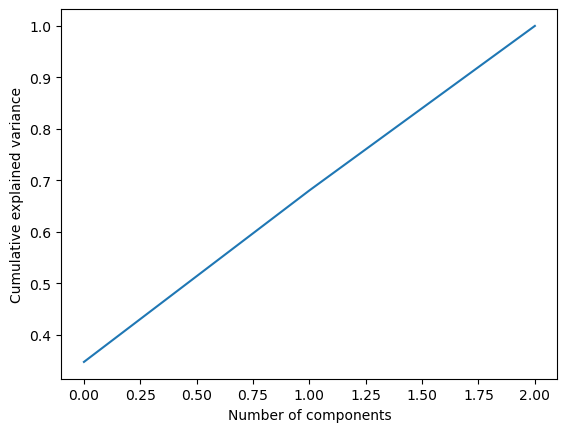

In [12]:
# Step 5: Use PCA for dimensionality reduction to visualize the importance of features
pca = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


In [13]:
pca_loadings = pd.DataFrame(pca.components_.T, index=df.columns[selector.get_support(indices=True)], columns=[f'PC{i+1}' for i in range(len(pca.components_))])
print(pca_loadings)


                  PC1       PC2       PC3
Invoice      0.680372 -0.255134  0.687023
StockCode   -0.208586 -0.966088 -0.152202
Description  0.702557 -0.039749 -0.710517


In [14]:
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_scaled)


In [15]:
k = 3  # Example cluster number
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(df_pca)


In [16]:
# Sample a smaller subset of the data for faster computation, e.g., 10%
sample_indices = np.random.choice(range(len(df_pca)), size=int(0.1 * len(df_pca)), replace=False)
df_pca_sample = df_pca[sample_indices]
clusters_sample = clusters[sample_indices]

# Calculate the silhouette score using the sampled data
# Use all available CPU cores for parallel processing
silhouette_avg = silhouette_score(df_pca_sample, clusters_sample, n_jobs=-1)

print(f"Silhouette Score for {k} clusters (sampled): {silhouette_avg:.3f}")

Silhouette Score for 3 clusters (sampled): 0.856


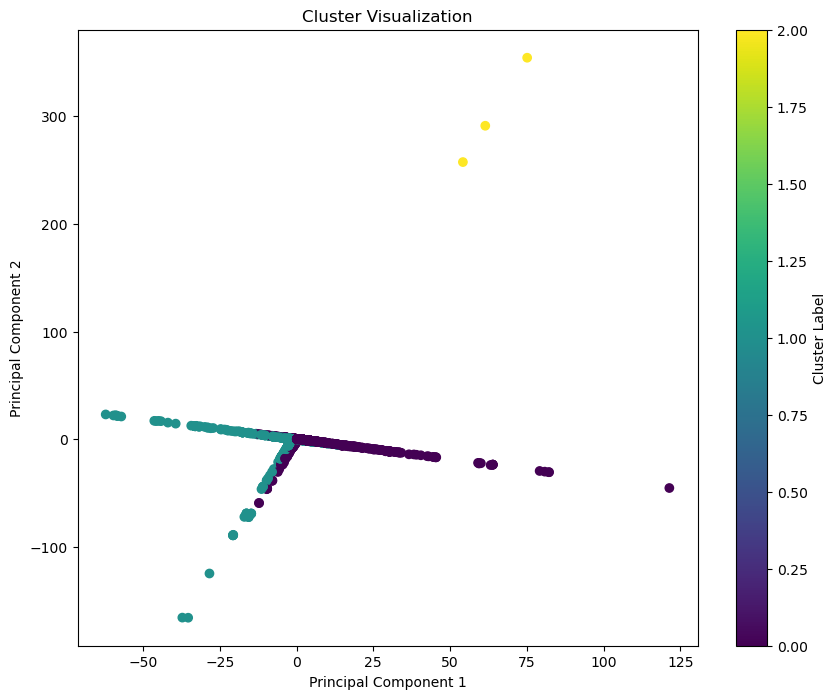

In [17]:
# Assuming df_pca contains your PCA reduced data and 'clusters' are the cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

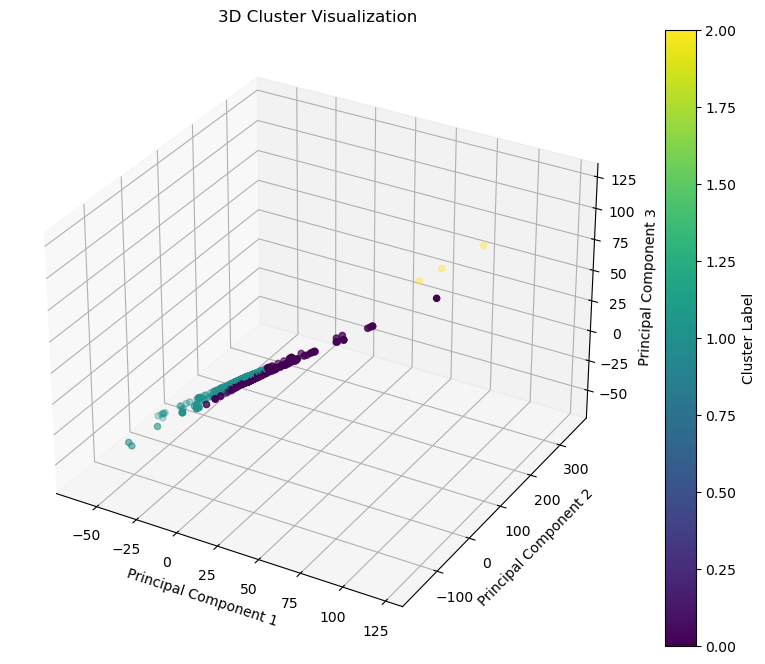

In [18]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], c=clusters, cmap='viridis', marker='o')

plt.title('3D Cluster Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc, label='Cluster Label')
plt.show()

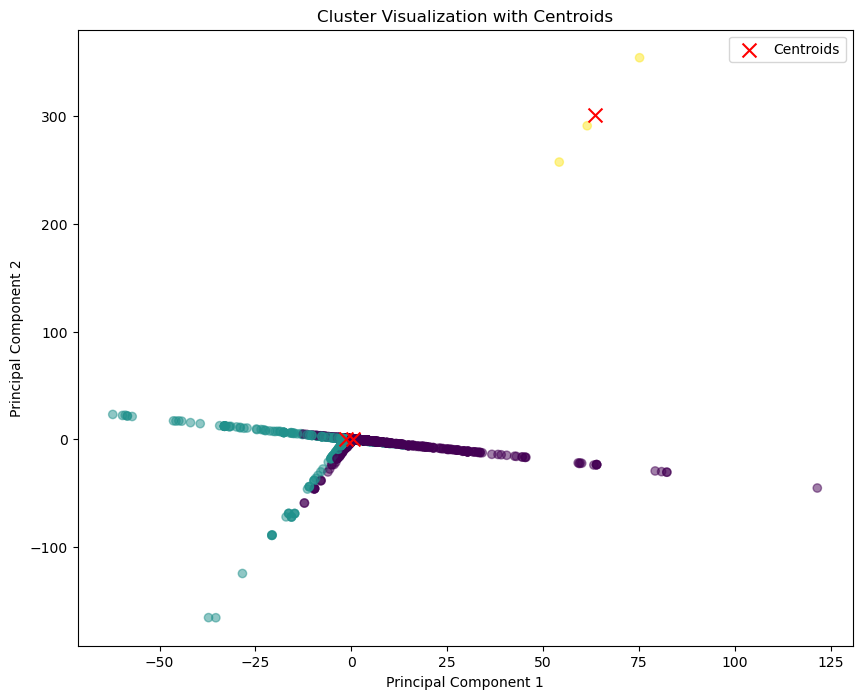

In [19]:
# Get centroids from the KMeans model
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title('Cluster Visualization with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [20]:
# Fit K-Means and predict clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_pca)

In [21]:
# Add the cluster labels to your DataFrame
df_pca_with_clusters = pd.DataFrame(df_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca_with_clusters['Cluster'] = clusters


In [22]:
# Characteristics of each cluster: Central tendencies and the spread
cluster_characteristics = df_pca_with_clusters.groupby('Cluster').agg(['mean', 'std']).reset_index()
print(cluster_characteristics)

  Cluster        PC1                    PC2                   PC3          
                mean        std        mean        std       mean       std
0       0   0.366628   0.674319   -0.019697   0.376537  -0.331768  0.691612
1       1  -1.420153   0.816323    0.067834   1.321057   1.282169  0.823397
2       2  63.577111  10.628967  301.058052  49.229254  48.713448  7.755817


In [23]:
# Size and distribution of clusters
cluster_sizes = df_pca_with_clusters['Cluster'].value_counts()
print(cluster_sizes)


0    417533
1    107925
2         3
Name: Cluster, dtype: int64


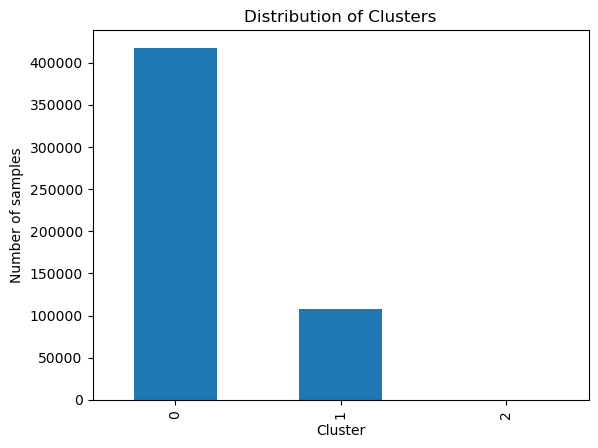

In [24]:
# Visual representation of cluster sizes
cluster_sizes.plot(kind='bar')
plt.ylabel('Number of samples')
plt.xlabel('Cluster')
plt.title('Distribution of Clusters')
plt.show()

In [25]:
# Potential outliers could be points that are far away from the cluster center
# You can define an outlier threshold as a factor of the standard deviation, e.g., points that are more than 3 standard deviations from the mean
outliers_threshold = 3
for cluster in np.unique(clusters):
    cluster_data = df_pca_with_clusters[df_pca_with_clusters['Cluster'] == cluster]
    distance_from_center = np.linalg.norm(cluster_data.iloc[:, :-1] - kmeans.cluster_centers_[cluster], axis=1)
    outliers = cluster_data[distance_from_center > np.mean(distance_from_center) + outliers_threshold * np.std(distance_from_center)]
    print(f"Potential outliers in cluster {cluster}:\n{outliers}")


Potential outliers in cluster 0:
             PC1       PC2       PC3  Cluster
217     4.024981 -1.338515  3.181426        0
575     5.085791 -1.858569  4.972874        0
3572    3.420515 -1.062192  2.175402        0
4793    3.003551 -1.099771  2.980863        0
6443    3.246234 -1.116513  2.734313        0
...          ...       ...       ...      ...
522087  6.455025 -2.331812  6.151076        0
522809  9.422312 -3.498761  9.391374        0
522918  9.391302 -3.294053  8.224439        0
522919  3.096056 -0.932025  1.867578        0
523543  3.312045 -1.008780  2.058765        0

[1126 rows x 4 columns]
Potential outliers in cluster 1:
              PC1        PC2        PC3  Cluster
3162    -8.007897   2.608698  -5.373190        1
4296    -6.278847   1.960317  -3.627237        1
4538    -5.962171   1.841566  -3.307465        1
6555     4.640139  -2.134221   7.398488        1
6556    -7.444214   2.397321  -4.803996        1
...           ...        ...        ...      ...
519294 -20.737

Cluster 0 centroid in PCA space: [ 0.366628   -0.01969705 -0.33176822]
Cluster 1 centroid in PCA space: [-1.42015307  0.0678341   1.28216856]
Cluster 2 centroid in PCA space: [ 63.57711124 301.05805176  48.71344803]


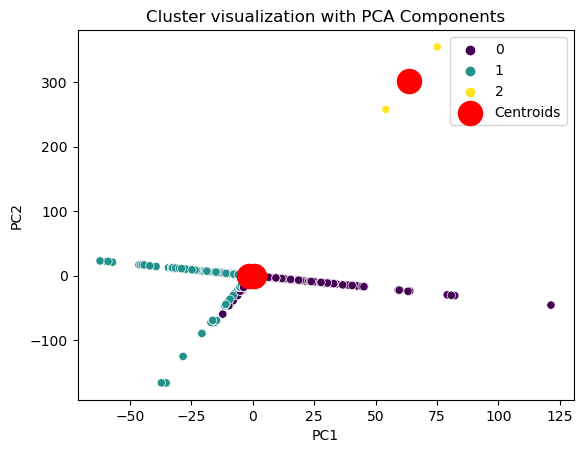

In [26]:
# Interpretation of the clusters based on their centroids
# For this, you would need domain knowledge to understand what each principal component represents
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"Cluster {i} centroid in PCA space: {center}")

# Visual representation of clusters in 2D (if you have 3 components, choose two for a 2D plot)
sns.scatterplot(x='PC1', y='PC2', data=df_pca_with_clusters, hue='Cluster', palette='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('Cluster visualization with PCA Components')
plt.legend()
plt.show()

In [27]:
basket_sets = (df
               .groupby(['Invoice', 'StockCode'])['Quantity']  # Group by Invoice and StockCode
               .sum().unstack().reset_index().fillna(0)        # Pivot the data
               .set_index('Invoice'))                          # Index by Invoice

# Convert quantities to 1s and 0s (presence of the item in the transaction)
basket_sets = basket_sets.applymap(lambda x: 1 if x > 0 else 0)


In [ ]:
# Run Apriori algorithm
frequent_itemsets_apriori = apriori(basket_sets, min_support=0.01, use_colnames=True)

# Calculate association rules
rules_apriori = association_rules(frequent_itemsets_apriori, metric="lift", min_threshold=1)